In [1]:
import openai
openai.api_key = 'your key'  
model_name = 'gpt-3.5-turbo'#'text-davinci-002' # CaP uses text-davinci-002

class ChatGPT():
    def __init__ (self, system_prompt, model_engine='text-davinci-003'):
        self.model_engine = model_engine
        self.system_prompt = system_prompt
        self.msg_history_davinci = self.system_prompt
        self.msg_history_turbo = [{"role": "assistant", "content": self.system_prompt}]
        self.role = 'user'
    
    def reset(self):
        self.msg_history_turbo = [{"role": "assistant", "content": self.system_prompt}]

    def get_answer(self, prompt=None):
        if self.model_engine == 'gpt-3.5-turbo':
            self.msg_history_turbo.append({"role": self.role, "content":prompt})
            response   = openai.ChatCompletion.create(
            model      = self.model_engine,
            temperature= 0.0,
            messages   = self.msg_history_turbo)
            reply_text = response['choices'][0]['message']['content']
            self.msg_history_turbo.append({"role":"assistant", "content":reply_text})

        elif self.model_engine == 'text-davinci-003': 
            self.msg_history_davinci += "You: "+prompt 
            response   = openai.Completion.create(
            engine     = self.model_engine,
            prompt     = self.msg_history_davinci,
            max_tokens = 512,
            temperature= 1.0,
            n          = 1,
            #stop       = ["You:", "AI:"]
            )
            reply_text = response.choices[0].text.strip().replace('Answer: ', '')
            self.msg_history_davinci+="\n"+"AI: "+reply_text+"\n"

        elif self.model_engine == 'text-davinci-002': 
            response   = openai.Completion.create(
            engine     = self.model_engine,
            prompt     = prompt,
            max_tokens = 512,
            temperature= 1.0,
            n          = 1,
            )
            reply_text = response['choices'][0]['text'].strip()
        return reply_text



In [25]:
sys_prompt = """
We have a manipulator and we want you to help plan how it should move to perform tasks using the
following APIs:
    def end_effector_to(position_obj)
position_obj is a list of 3 float numbers [x,y,z]
    def end_effector_open()
Open the end effector
    def get_object_center_position(obj_name)
Given an object name, return a list of 3 float numbers [x,y,z] for the object position.
    def get_object_size(obj_name)
Given an object name, return a list of 3 float numbers [x,y,z] for the object size.
    def get_current_position()
Return a list of 3 float numbers [x,y,z] for the current position of the end effector.
    def normalize_table_position(position_obj)
Given a position, return a normalized position that is on the table.
    def denormalize_table_position(position_obj)
Given a normalized position, return a position that is on the table.
    def check_empty(position_obj)
Return True if the position is empty, False otherwise.

Example answer code:
    import numpy as np
    # place the object in the dish_rack
    def place_object_in_dish_rack():
        object_pos = get_object_center_position('dish_rack')
        object_size = get_object_size('dish_rack')
        range_y = [object_pos[1] - object_size[1] + 0.05 , object_pos[1] + object_size[1]-0.05]
        for y in np.linspace(range_y[0], range_y[1], 10):
            target_pos = [object_pos[0], y, object_pos[2]+0.2]
            empty = check_empty(target_pos)
            if empty:
                end_effector_to(target_pos)
                end_effector_open()
                return
    place_object_in_dish_rack()
                

    # place the object on the center of the table
    target_pos = [0, 0, 0]
    target_pos = denormalize_table_position(target_pos)
    end_effector_to(target_pos)
    end_effector_open()

Remember:
1. Always format the code in code blocks.
2. Do not invent new functions or classes. The only allowed functions you can call are the ones listed
above. Do not leave unimplemented code blocks in your response.
3. The only allowed library is numpy. Do not import or use any other library.
4. If you are not sure what value to use, just use your best judge. Do not use None for anything.
5. You do not need to make the robot do extra things not mentioned in the plan such as stopping the
robot.
6. Try your best to generate code despite the lack of context.
7. Only use end_effector_to, end_effector_open once in your code.
"""
llm = ChatGPT(sys_prompt, model_engine=model_name)
llm.reset()


### ENV

In [3]:
import mujoco #cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../')
from utils.mujoco_parser import MuJoCoParserClass

from utils.util import sample_xyzs,rpy2r,r2rpy,r2quat,compute_view_params,get_interp_const_vel_traj, printmd
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

/home/rilab/.pyenv/versions/3.10.12/envs/llm_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-10 19:32:41,309	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


MuJoCo version:[2.3.7]


In [4]:
xml_path = '../../../asset/scene_kitchen_dish_rack_black.xml'
env = MuJoCoParserClass(name='Place task scene: Plate table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('base').pos = np.array([0.18,0,0.79])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-1.5,0.80,0])

# Place objects
obj_box_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_box"))]
n_box_obj = len(obj_box_names)
env.place_objects_random(n_obj=n_box_obj, obj_names=obj_box_names, x_range=[0.80, 1.15], y_range=[-3.15, -2.15], COLORS=False, VERBOSE=True)

jntadr_mug_cup = env.model.body('mug_cup').jntadr[0]
env.model.joint(jntadr_mug_cup).qpos0[:3] = np.array([ 0.9, -0.3, 0.85])
env.model.joint(jntadr_mug_cup).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, np.random.rand() * 360])))

jntadr_tray = env.model.body('tray').jntadr[0]
env.model.joint(jntadr_tray).qpos0[:3] = np.array([0.9,-0.3,0.80])
# env.model.joint(jntadr_tray).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, 0])))

jntadr_dish_rack = env.model.body('kitchen-drainer').jntadr[0]
pos_dish_rack = np.array([0.9,0.35,0.82])
env.model.joint(jntadr_dish_rack).qpos0[:3] = pos_dish_rack
dish_rack_random_rot = 0 # np.random.rand() * 360
env.model.joint(jntadr_dish_rack).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, dish_rack_random_rot])))


# Target dish
env.model.joint(env.model.body('kitchen-plate').jntadr[0]).qpos0[:3] = np.array([0.2, -0.7, 0.8])
# Set the dishes
env.model.joint(env.model.body('kitchen-plate-2').jntadr[0]).qpos0[:3] = pos_dish_rack + np.array([0.,-0.06, 0.25])
env.model.joint(env.model.body('kitchen-plate-2').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 90, 90])))
env.model.joint(env.model.body('kitchen-plate-3').jntadr[0]).qpos0[:3] = pos_dish_rack + np.array([0., -0.12, 0.25])
env.model.joint(env.model.body('kitchen-plate-3').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 90, 90])))
env.model.joint(env.model.body('kitchen-plate-4').jntadr[0]).qpos0[:3] = pos_dish_rack + np.array([-3.5, 0., 0.25])
env.model.joint(env.model.body('kitchen-plate-4').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 90, 90])))

env.reset()

window


In [5]:
object_info_dict = dict()
drainer_size = [0.17, 0.07, 0.28]#env.model.geom_aabb[env.model.body('kitchen-drainer').geomadr][0][3:]
plate_size2  =  [0.14, 0.14, 0.01] #env.model.geom_aabb[env.model.body('kitchen-plate-2').geomadr][0][3:]
plate_size3  =  [0.14, 0.14, 0.01] #env.model.geom_aabb[env.model.body('kitchen-plate-3').geomadr][0][3:]
table_size   = env.model.geom_aabb[env.model.body('avoiding_object_table').geomadr][0][3:]
tray_size    =  [0.11, 0.15, 0.01]#env.model.geom_aabb[env.model.body('tray').geomadr][0][3:]
mug_cup_size = [0.05, 0.07, 0.07]# env.model.geom_aabb[env.model.body('mug_cup').geomadr][0][3:]

# object_lst = ['base_table', 'avoiding_object_table', 'left_object_table',
#               'kitchen-drainer','tray','mug_cup',
#               'kitchen-plate','kitchen-plate-2','kitchen-plate-3','kitchen-plate-4']
print(table_size)

object_info_dict['kitchen-drainer'] = {'name':"dish_rack", 'size': drainer_size, 'position': [0.9,0.35,0.82], 'rotation':[-0.01, 0.02, -0.]}
object_info_dict['kitchen-plate-2'] = {'name':"dish2", 'size': plate_size2, 'position': [0.87, 0.26, 0.9 ], 'rotation':[-0.49,  1.32,  1.06]}
object_info_dict['kitchen-plate-3'] = {'name':"dish3", 'size': plate_size3, 'position': [0.9,  0.22, 0.89], 'rotation':[-0.04,  1.41,  1.52]}
object_info_dict['tray']            = {'name':"tray", 'size': tray_size, 'position': [ 0.9,  -0.3,   0.8], 'rotation':[1.57,   0.,   1.57]}
object_info_dict['mug_cup']         = {'name':"mug cup", 'size': mug_cup_size, 'position': [ 0.9, -0.3, 0.85], 'rotation':[-0.01, -0.01,  2.58]}
object_info_dict['avoiding_object_table'] = {'name':"table", 'size': table_size, 'position': [0.38+0.45, 0., 0.8], 'rotation':[0., 0., 0.]}

[0.45 0.6  0.37]


In [6]:
object_lst = ['base_table', 'avoiding_object_table', 'left_object_table',
              'kitchen-drainer','tray','mug_cup',
              'kitchen-plate','kitchen-plate-2','kitchen-plate-3','kitchen-plate-4']
for object_name in object_lst:
    p_obj,R_obj = env.get_pR_body(body_name=object_name)
    print("Name: {} / Position:{} / RPY: {}".format(object_name, p_obj, r2rpy(R_obj)))


Name: base_table / Position:[0. 0. 0.] / RPY: [ 0. -0.  0.]
Name: avoiding_object_table / Position:[0.83 0.   0.  ] / RPY: [ 0. -0.  0.]
Name: left_object_table / Position:[-1.5  0.8  0. ] / RPY: [ 0. -0.  0.]
Name: kitchen-drainer / Position:[0.9  0.35 0.82] / RPY: [ 0. -0.  0.]
Name: tray / Position:[ 0.9 -0.3  0.8] / RPY: [1.57 0.   1.57]
Name: mug_cup / Position:[ 0.9  -0.3   0.85] / RPY: [ 0. -0.  1.]
Name: kitchen-plate / Position:[ 0.2 -0.7  0.8] / RPY: [ 0. -0.  0.]
Name: kitchen-plate-2 / Position:[0.9  0.29 1.07] / RPY: [0.79 1.57 2.36]
Name: kitchen-plate-3 / Position:[0.9  0.23 1.07] / RPY: [0.79 1.57 2.36]
Name: kitchen-plate-4 / Position:[-2.6   0.35  1.07] / RPY: [0.79 1.57 2.36]


In [22]:
seen_obj_names = []
for name in object_info_dict.values():
    seen_obj_names.append(name['name'])
seen_obj_names.append('dish1')

In [26]:
llm.reset()
prompt = "# you are now holding a dish1. Place the dish1 on location that best fit the common-sense\n"
prompt += "seen_objects = "+str(seen_obj_names)+"\n"
prompt += "# dish2 and dish3 are on the dish_rack.\n"
prompt += "# mug_cup is on the tray.\n"
print(prompt)
code = llm.get_answer(prompt=prompt)

# you are now holding a dish1. Place the dish1 on location that best fit the common-sense
seen_objects = ['dish_rack', 'dish2', 'dish3', 'tray', 'mug cup', 'table', 'dish1']
# dish2 and dish3 are on the dish_rack.
# mug_cup is on the tray.



In [27]:
print(code)

import numpy as np

# place the dish1 on the dish_rack
def place_dish1_on_dish_rack():
    dish_rack_pos = get_object_center_position('dish_rack')
    dish_rack_size = get_object_size('dish_rack')
    range_y = [dish_rack_pos[1] - dish_rack_size[1] + 0.05 , dish_rack_pos[1] + dish_rack_size[1]-0.05]
    for y in np.linspace(range_y[0], range_y[1], 10):
        target_pos = [dish_rack_pos[0], y, dish_rack_pos[2]+0.2]
        empty = check_empty(target_pos)
        if empty:
            end_effector_to(target_pos)
            end_effector_open()
            return

# place the dish1 on the tray
def place_dish1_on_tray():
    tray_pos = get_object_center_position('tray')
    tray_size = get_object_size('tray')
    range_y = [tray_pos[1] - tray_size[1] + 0.05 , tray_pos[1] + tray_size[1]-0.05]
    for y in np.linspace(range_y[0], range_y[1], 10):
        target_pos = [tray_pos[0], y, tray_pos[2]+0.2]
        empty = check_empty(target_pos)
        if empty:
            end_effector_to(targ

In [13]:
'''
define functions
'''
def end_effector_to(position_obj):
    target_obj_name = 'kitchen-plate'
    target_obj_jntadr = env.model.body(target_obj_name).jntadr[0]
    target_obj_qposadr = env.model.jnt_qposadr[target_obj_jntadr]
    env.data.qpos[target_obj_qposadr:target_obj_qposadr+3] = position_obj
    env.data.qpos[target_obj_qposadr+3:target_obj_qposadr+7] = r2quat(rpy2r(np.radians([0, 90, 90])))
    print("Move the end effector to {}".format(position_obj))
    #position_obj is a list of 3 float numbers [x,y,z]

def end_effector_open():
    #Open the end effector
    pass
def get_object_center_position(obj_name):
    #Given an object name, return a list of 3 float numbers [x,y,z] for the object position.
    for obj in object_info_dict:
        if object_info_dict[obj]['name'] == obj_name or obj == obj_name:
            return object_info_dict[obj]['position']
    
    print("Object {} not found".format(obj_name))
    current_pos = get_current_position()
    return current_pos
    
def get_object_size(obj_name):
    # Given an object name, return a list of 3 float numbers [x,y,z] for the object size.
    for obj in object_info_dict:
        if object_info_dict[obj]['name'] == obj_name or obj == obj_name:
            print("Object {} found".format(obj_name))
            return object_info_dict[obj]['size']
    return [0.0,0.0,0.0]  
def get_current_position():
    # Return a list of 3 float numbers [x,y,z] for the current position of the end effector.
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    return p_tcp

def normalize_table_position(position_obj):
    #Given a position, return a normalized position that is on the table.
    table_size = object_info_dict['avoiding_object_table']['size']#env.model.geom_aabb[env.model.body('base_table').geomadr][0][3:]
    table_pos =object_info_dict['avoiding_object_table']['position'] #env.model.body('base_table').pos
    normalized_pos = (position_obj - table_pos) / (table_size)
    return normalized_pos
def denormalize_table_position(position_obj):
    #Given a normalized position (0-1), return a position that is on the table.
    table_size = object_info_dict['avoiding_object_table']['size']#env.model.geom_aabb[env.model.body('base_table').geomadr][0][3:]
    table_pos =object_info_dict['avoiding_object_table']['position'] #env.model.body('base_table').pos
    denormalized_pos = position_obj * (table_size)+ table_pos
    denormalized_pos[2] = 0.9
    return denormalized_pos

def check_empty(position_obj):
    # Return True if the position is empty, False otherwise.
    for obj in object_info_dict:
        obj_pos = object_info_dict[obj]['position']
        obj_pos = np.array(obj_pos)
        if np.linalg.norm(obj_pos - position_obj) < 0.05:
            return False
    return True

In [14]:
table_size = env.model.geom_aabb[env.model.body('avoiding_object_table').geomadr][0][3:]
table_pos = env.model.body('avoiding_object_table').pos
print("Table size: {} / Table pos: {}".format(table_size, table_pos))

Table size: [0.45 0.6  0.37] / Table pos: [0.83 0.   0.  ]


In [29]:
obj_names = [object_info_dict[obj]['name'] for obj in object_info_dict]
obj_names.append('dish')
code_in = 'seen_objects = ' + str(obj_names)
code_in += '\n' + code

Object dish_rack found
Move the end effector to [0.9, 0.32999999999999996, 1.02]
[ 0.5  -0.01  1.16]


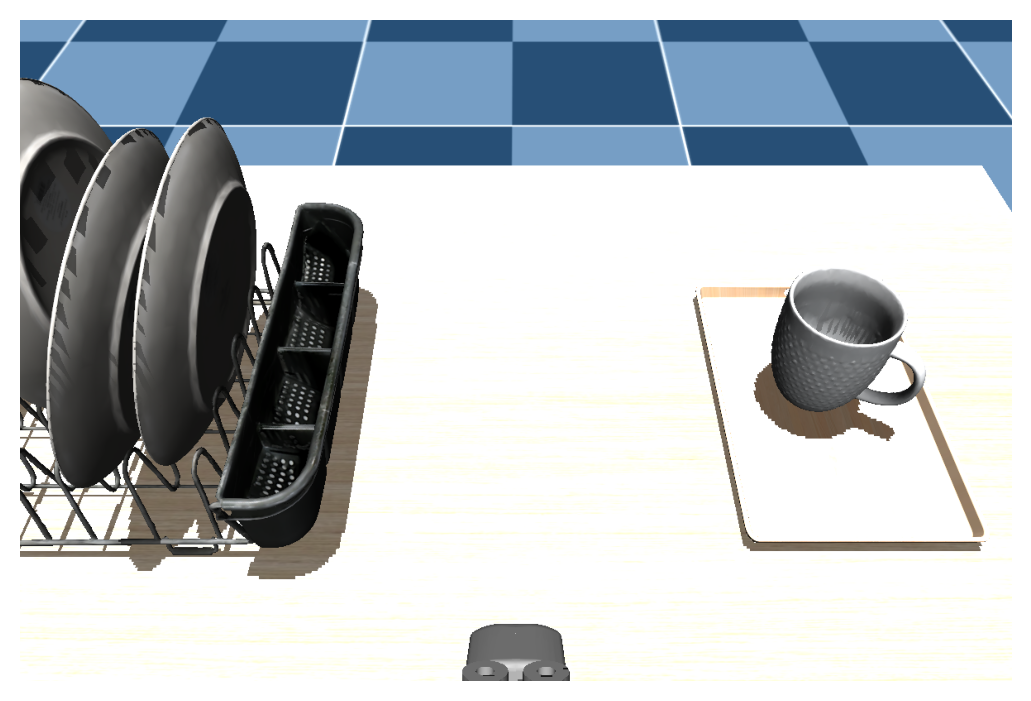

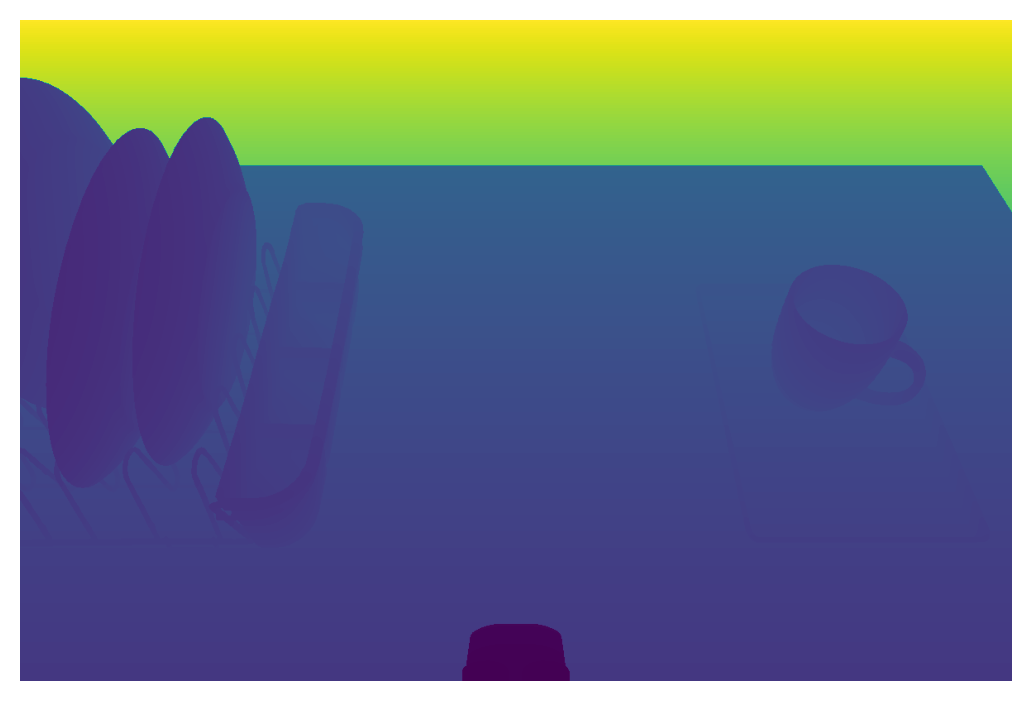

Done. Tick:[6052] Time:[12.10]sec


In [30]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=30,distance=3.0,elevation=-30,lookat=[1.0,0.0,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0
env.reset()
exec(code_in)
init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))

tick,max_sec = 0,1000
while env.get_sim_time() <= max_sec:
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] + np.array([0,0,-0.1])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        env.render(render_every=1)

plt.imshow(rgb_img); plt.axis('off'); plt.show()
plt.imshow(depth_img); plt.axis('off'); plt.show()

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))